### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Directorio de imágenes

In [38]:
base_dir = 'images'
train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir, 'test')

### Escalamiento y Preprocesado

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normaliza a [0, 1]
    rotation_range=30,
    width_shift_range=0.2,         
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest'
)

Found 2459 images belonging to 5 classes.
(9, 150, 150, 3)
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


<Figure size 640x480 with 0 Axes>

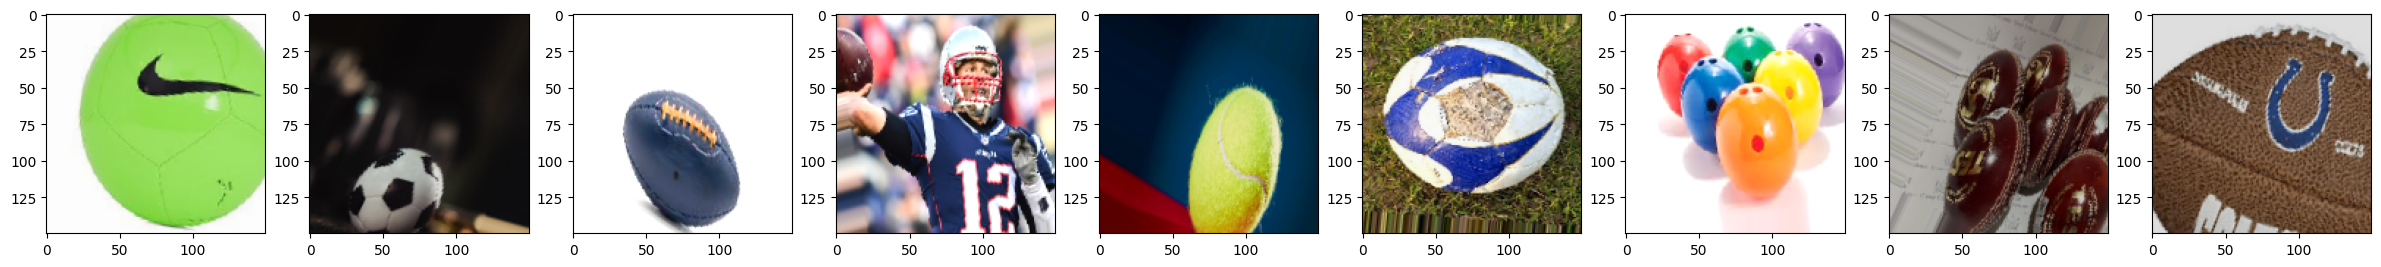

In [42]:
train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size = (150, 150),
	batch_size = 9,  
	class_mode ='categorical', # 'categorical' para más de 2 clases a clasificar
	shuffle = True 
)

images , labels = train_generator[0]

print(images.shape)
print(labels)

plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]) :
	axarr[i].imshow(images[i]) 

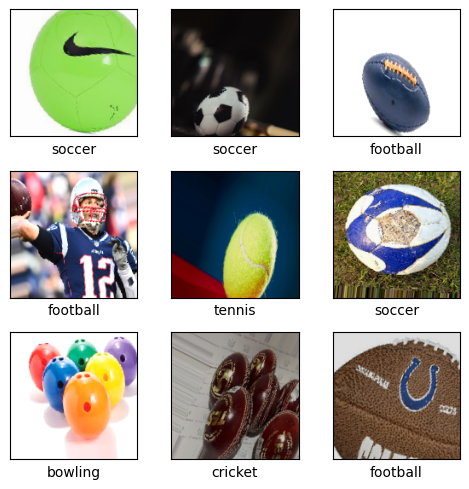

In [43]:
# Convertir etiquetas one-hot a índices
label_indices = np.argmax(labels, axis=1)
class_names = list(train_generator.class_indices.keys())

# Mostrar 25 imágenes en color
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Mostrar imagen en color directamente (sin cmap)
    plt.imshow(images[i])
    
    # Mostrar la etiqueta abajo
    plt.xlabel(class_names[label_indices[i]])
plt.tight_layout()
plt.show()